In [18]:
# data import
library(tidyverse)
HFdataset <- read.csv('heart_failure.csv')
# View summary
summary(HFdataset)

##########################################
# Global Settings

# Set random seed
set.seed(123)

#Set whether SMOTE is turned on, 1 means resampling starts, 0 means no resampling
# After resampling, the effect is much better, but not resampling is also part of the trial, so keep this switch.
SMOTE_enabled <- 1

##########################################

      age           anaemia       creatinine_phosphokinase    diabetes     
 Min.   :40.00   Min.   :0.0000   Min.   :  23.0           Min.   :0.0000  
 1st Qu.:51.00   1st Qu.:0.0000   1st Qu.: 116.5           1st Qu.:0.0000  
 Median :60.00   Median :0.0000   Median : 250.0           Median :0.0000  
 Mean   :60.83   Mean   :0.4314   Mean   : 581.8           Mean   :0.4181  
 3rd Qu.:70.00   3rd Qu.:1.0000   3rd Qu.: 582.0           3rd Qu.:1.0000  
 Max.   :95.00   Max.   :1.0000   Max.   :7861.0           Max.   :1.0000  
 ejection_fraction high_blood_pressure   platelets      serum_creatinine
 Min.   :14.00     Min.   :0.0000      Min.   : 25100   Min.   :0.500   
 1st Qu.:30.00     1st Qu.:0.0000      1st Qu.:212500   1st Qu.:0.900   
 Median :38.00     Median :0.0000      Median :262000   Median :1.100   
 Mean   :38.08     Mean   :0.3512      Mean   :263358   Mean   :1.394   
 3rd Qu.:45.00     3rd Qu.:1.0000      3rd Qu.:303500   3rd Qu.:1.400   
 Max.   :80.00     Max.   :1.0

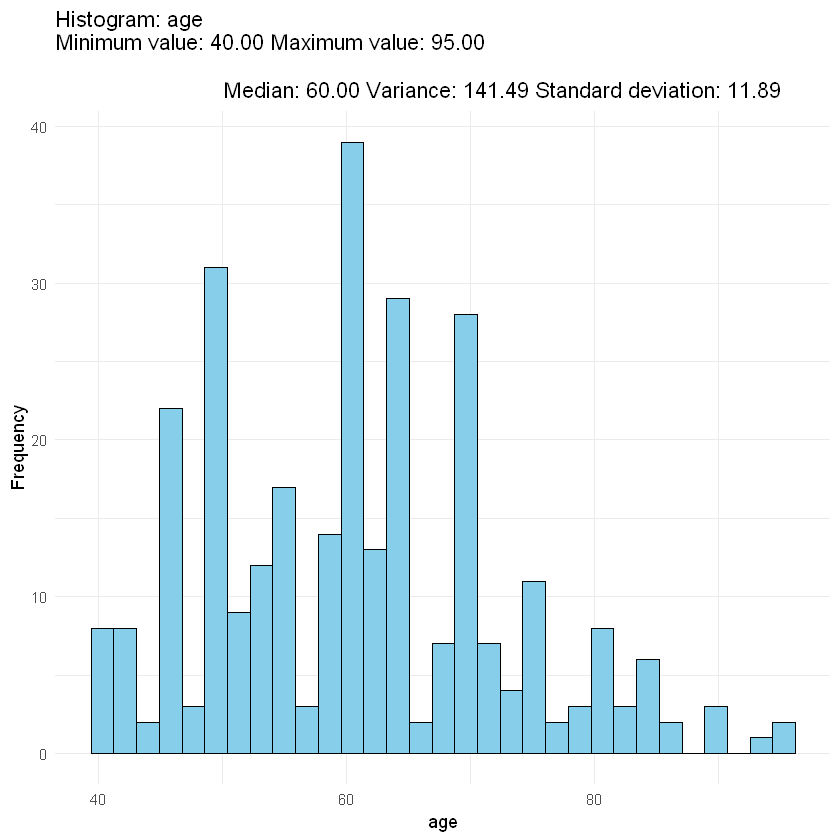

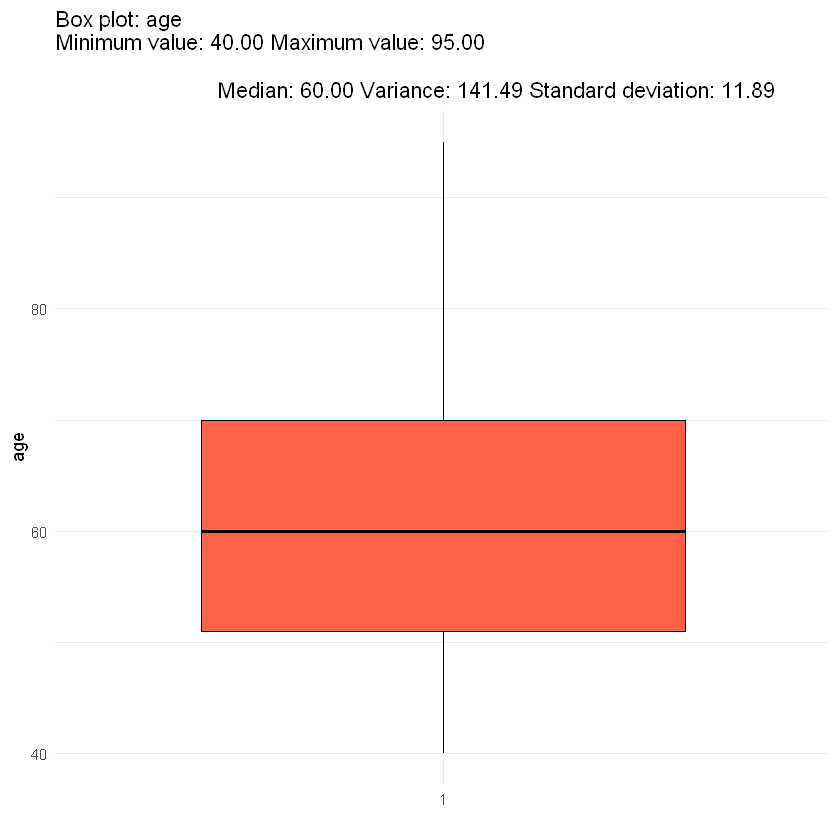

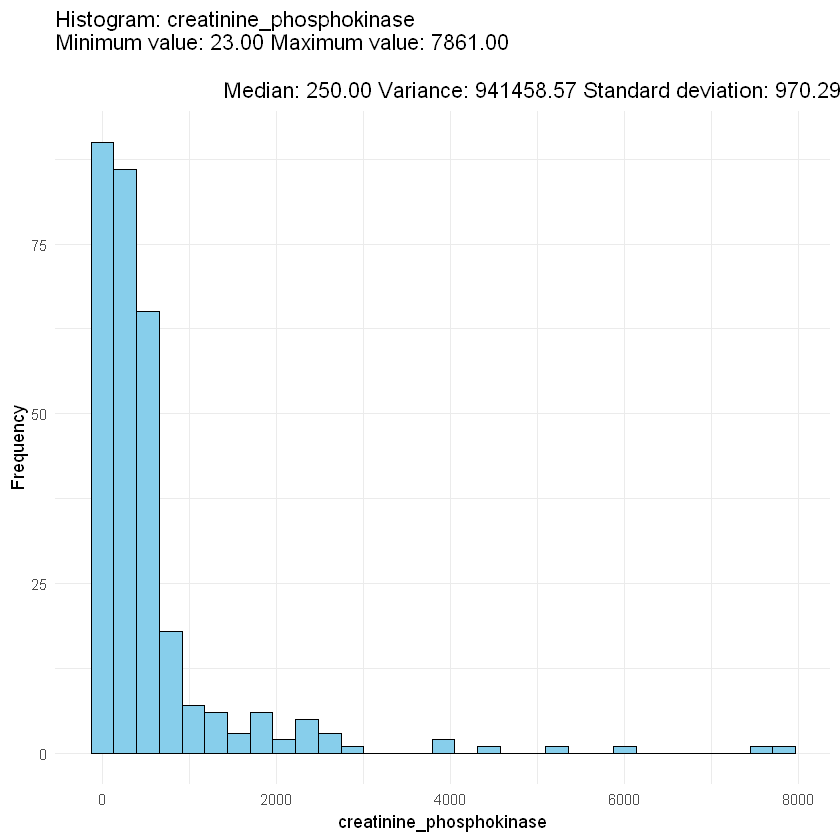

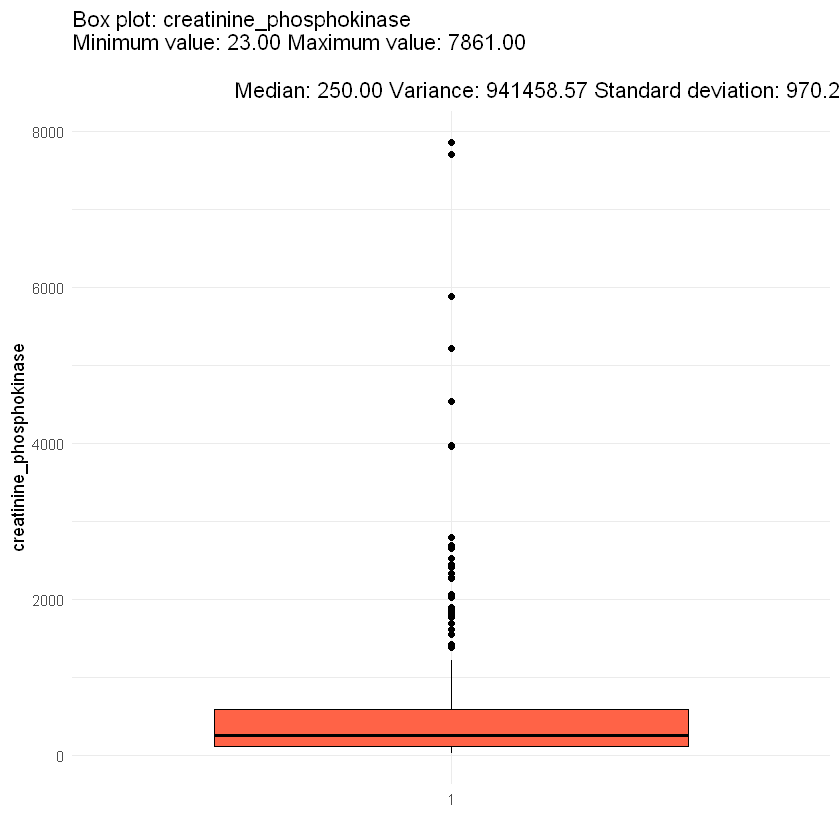

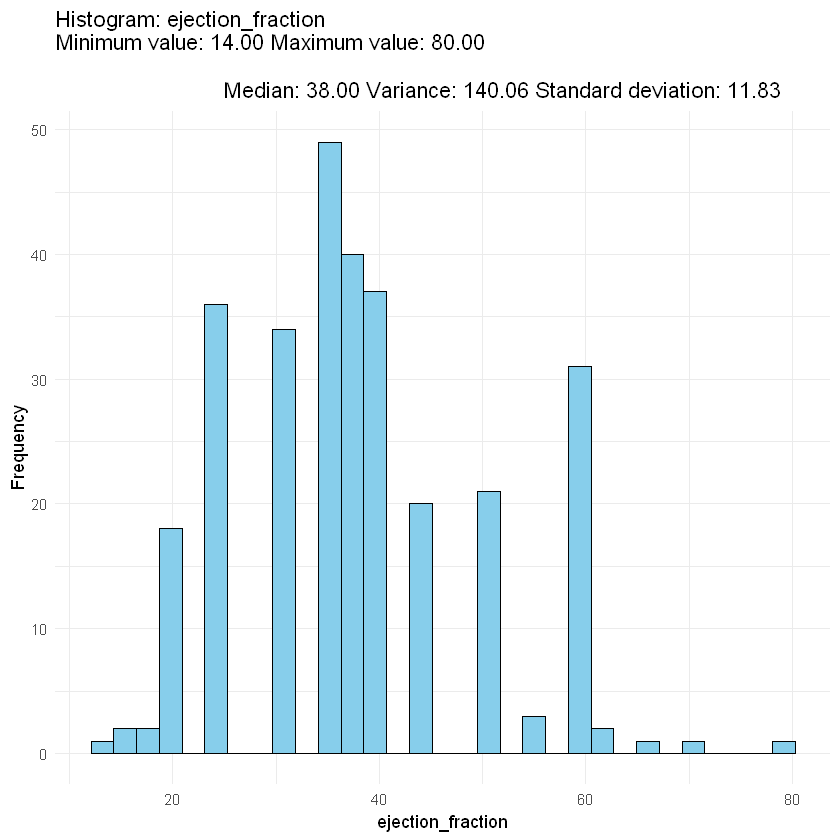

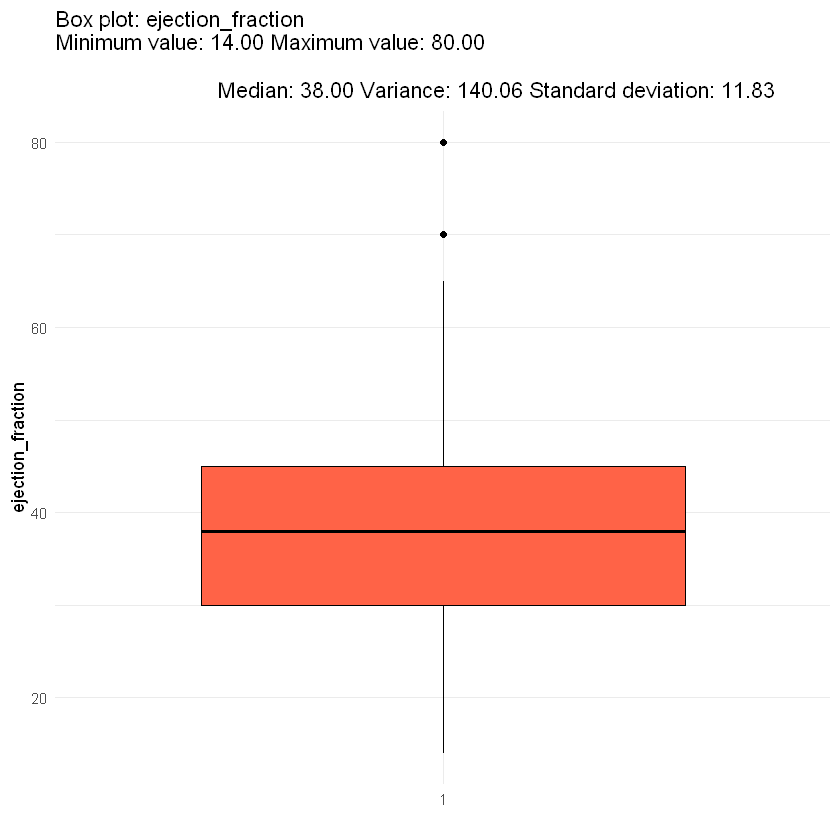

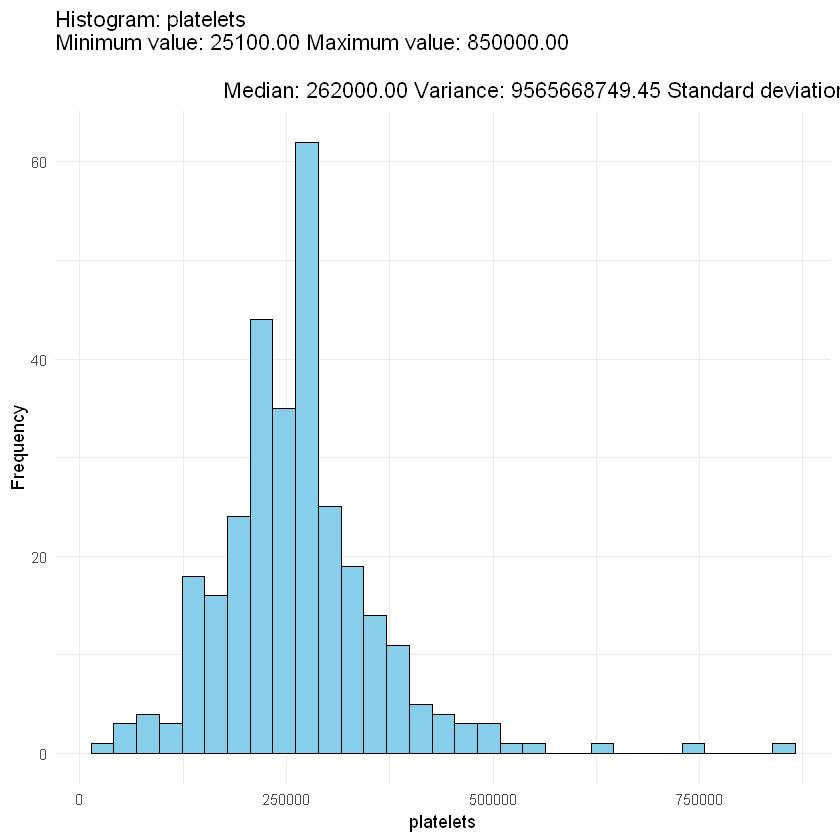

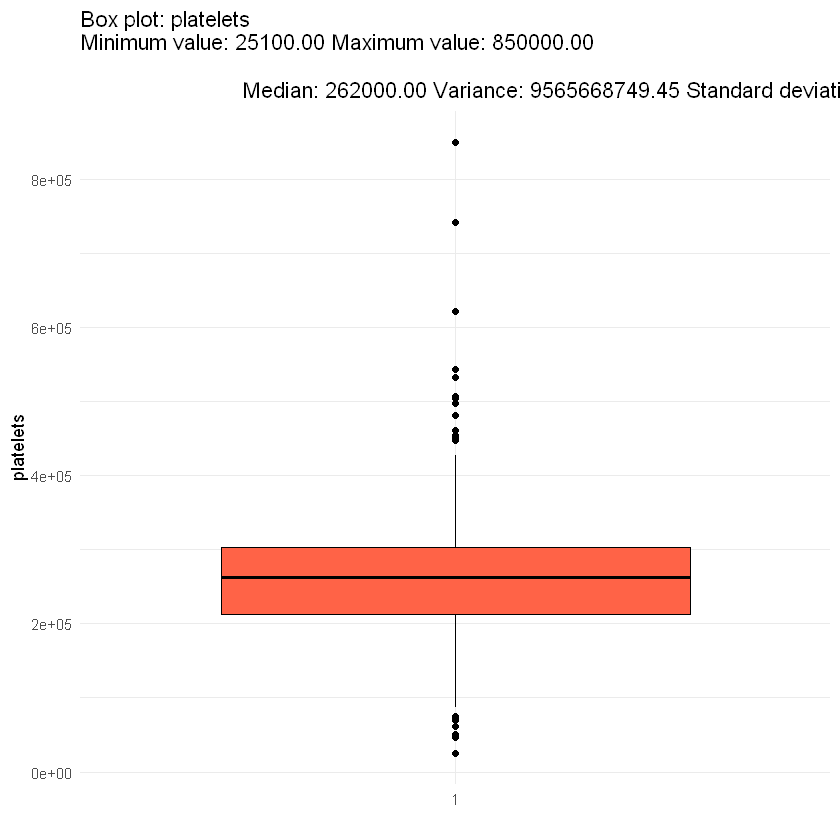

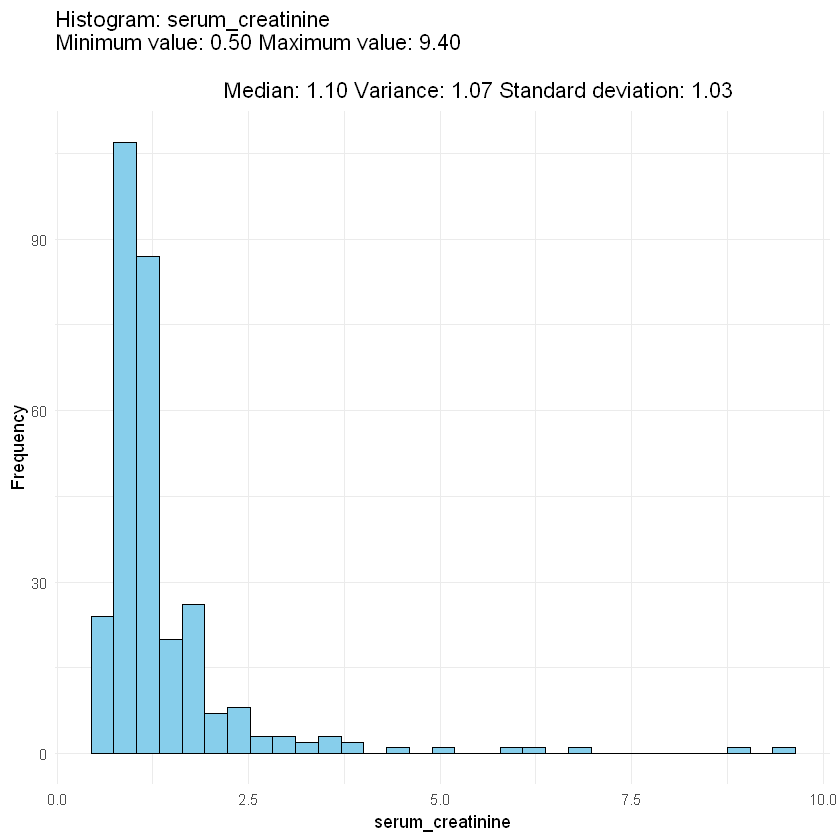

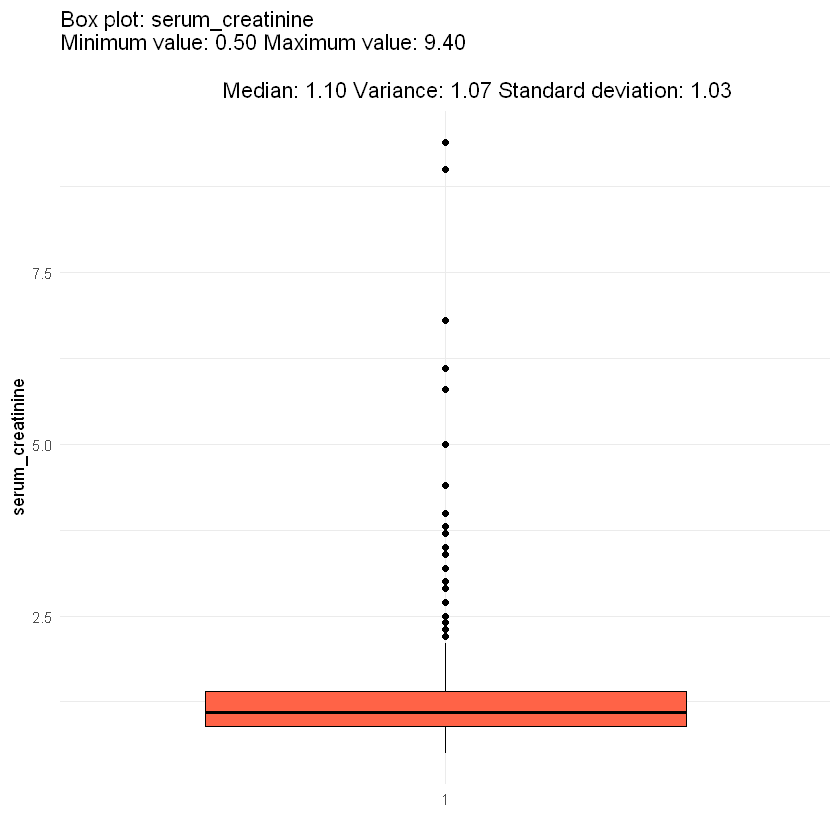

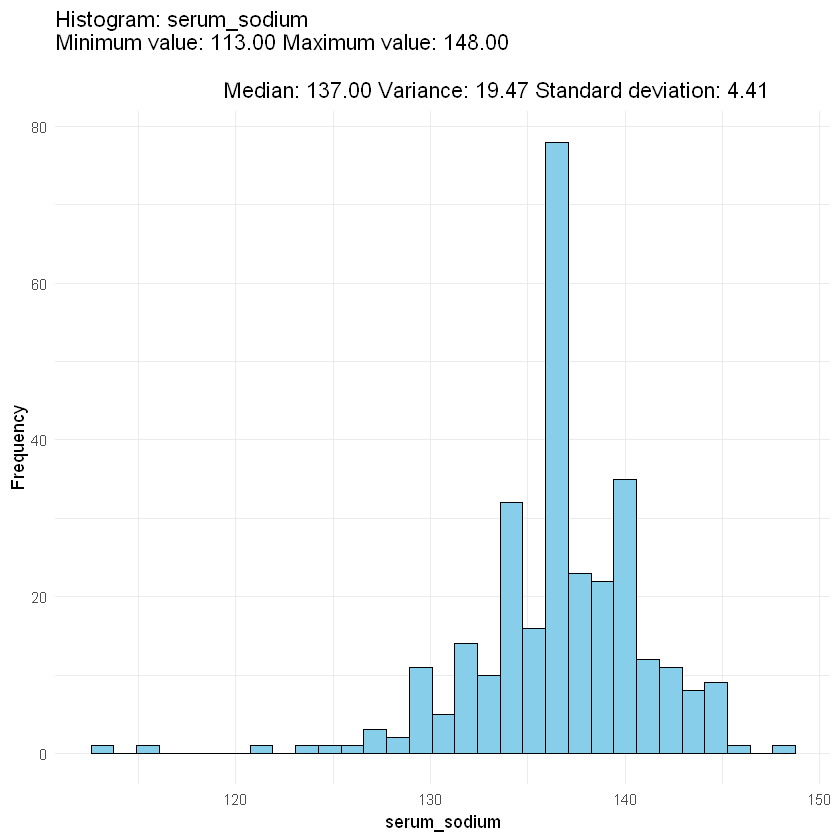

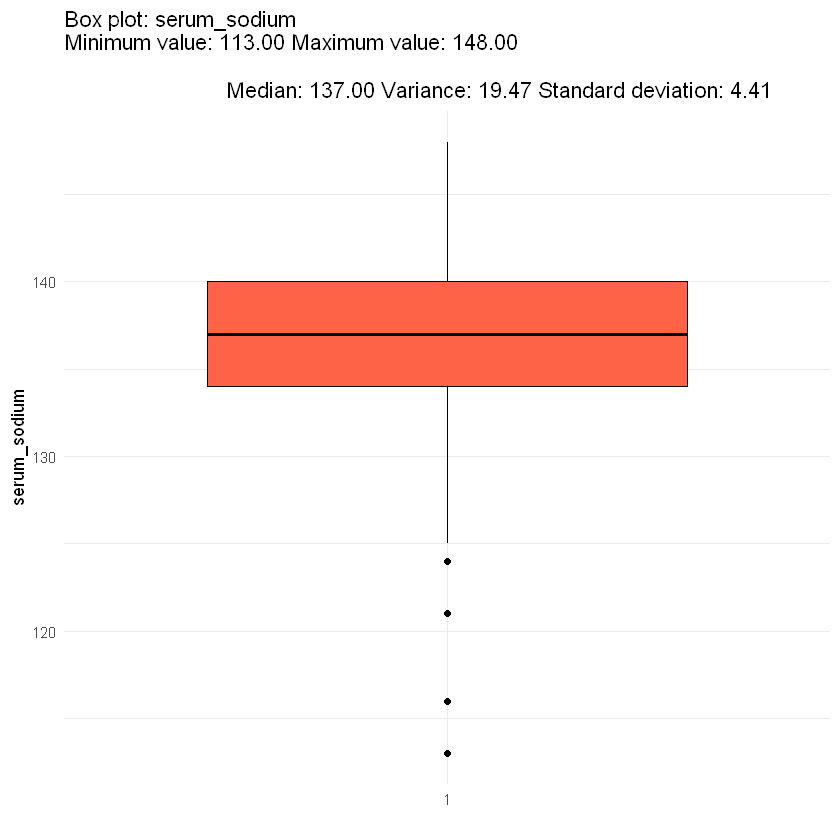

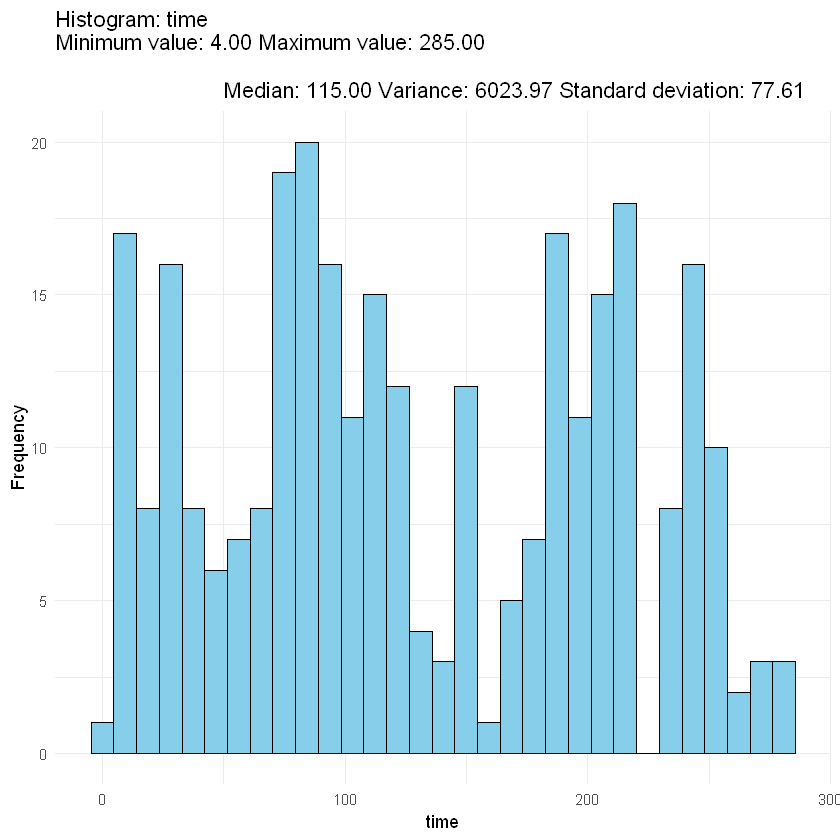

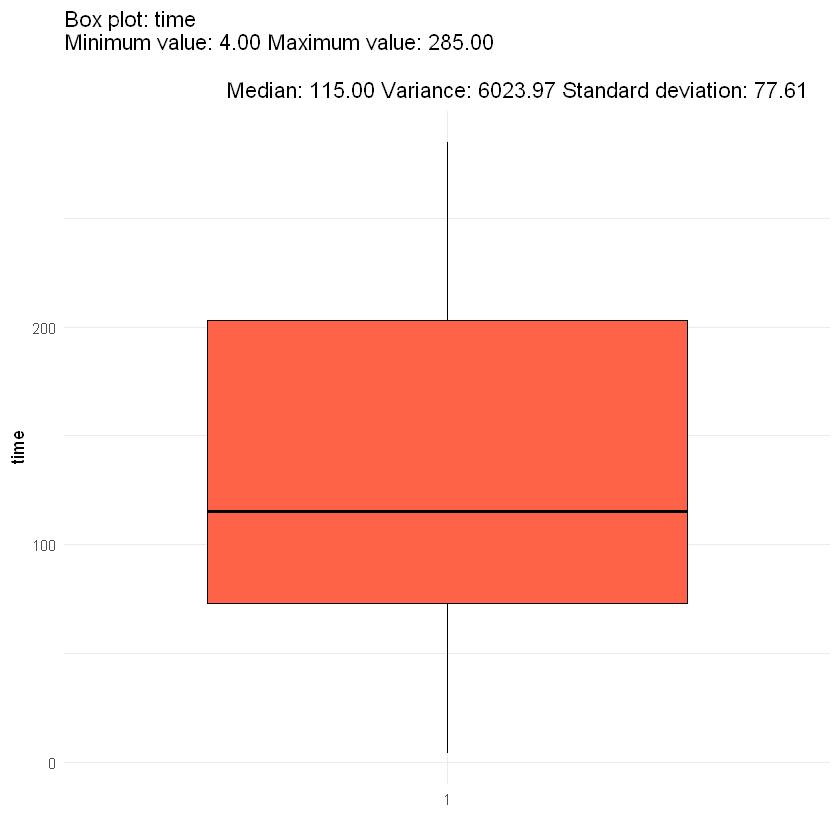

In [19]:
# Preliminary data analysis, descriptive analysis and visualization
# Draw charts in batches
library(tidyverse)

# Define variable list
varlist <- c("age", "creatinine_phosphokinase", "ejection_fraction",
                "platelets", "serum_creatinine", "serum_sodium", "time")


#Loop through each variable and draw histograms and boxplots for each variable
for (vari in varlist) {
   # Calculate statistics
   MinValues <- min(HFdataset[[vari]], na.rm = TRUE)
   MaxValues <- max(HFdataset[[vari]], na.rm = TRUE)
   MedValues <- median(HFdataset[[vari]], na.rm = TRUE)
   varValues <- var(HFdataset[[vari]], na.rm = TRUE)
   SDValues <- sd(HFdataset[[vari]], na.rm = TRUE)
  
   # Format and display basic information on the title
   HistTitleInfo <- sprintf("Histogram: %s\nMinimum value: %.2f Maximum value: %.2f\n
                            Median: %.2f Variance: %.2f Standard deviation: %.2f",
                            vari, MinValues, MaxValues, MedValues, varValues, SDValues)
  
   # Draw histogram
   HistPlot <- ggplot(HFdataset, aes_string(x = vari)) +
     geom_histogram(fill = "skyblue", color = "black", binwidth = diff(range(HFdataset[[vari]], na.rm = TRUE))/30) +
     theme_minimal() +
     labs(title = HistTitleInfo, x = vari, y = "Frequency")
   print(HistPlot)

   # Draw box plot
   BoxTitleInfo <- sprintf("Box plot: %s\nMinimum value: %.2f Maximum value: %.2f\n
                           Median: %.2f Variance: %.2f Standard deviation: %.2f",
                           vari, MinValues, MaxValues, MedValues, varValues, SDValues)
   BoxPlot <- ggplot(HFdataset, aes_string(x = factor(1), y = vari)) +
     geom_boxplot(fill = "tomato", color = "black") +
     theme_minimal() +
     labs(title = BoxTitleInfo, x = "", y = vari)
   print(BoxPlot)
}

# Problem Description

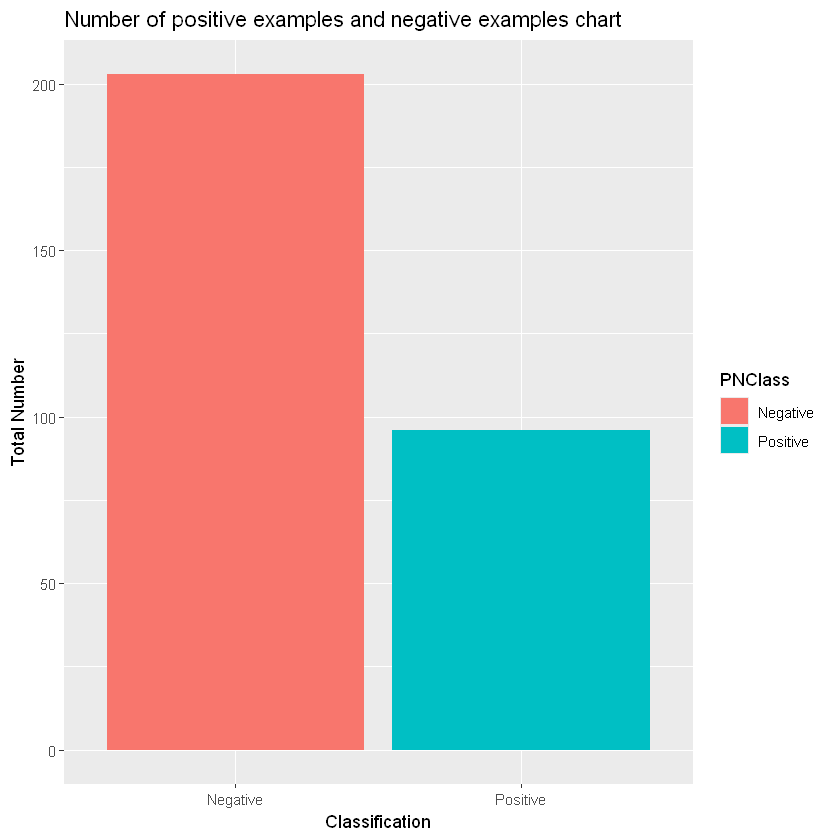

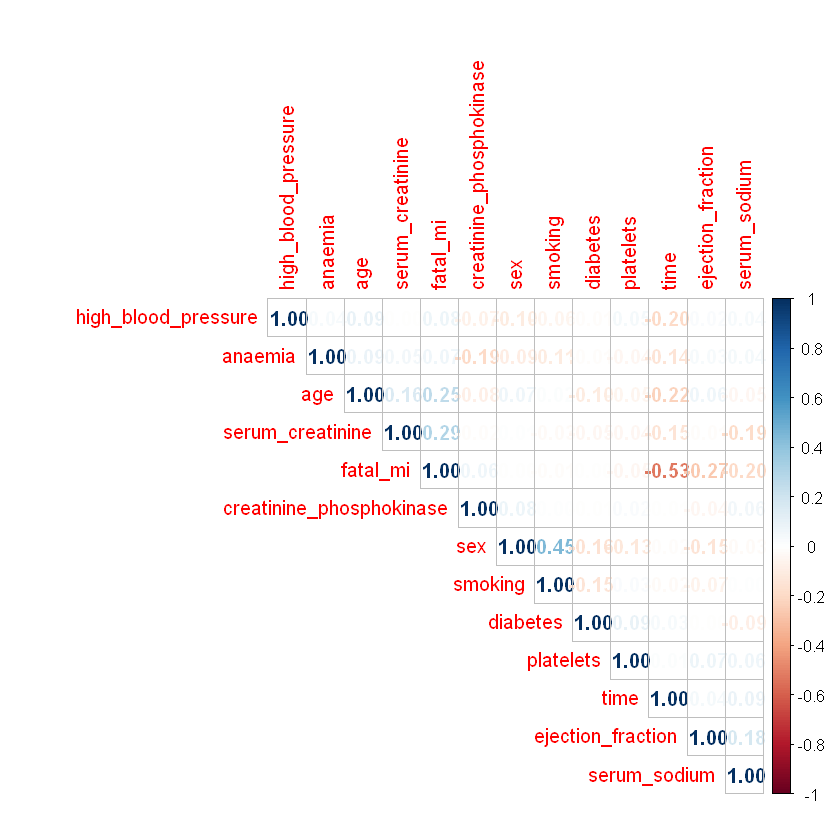

In [20]:
# Preliminary data analysis, counting the number of positive examples and negative examples, and drawing correlation analysis diagrams between features
data <- data.frame(
  PNClass = c("Positive", "Negative"),
  Nums = c(sum(HFdataset$fatal_mi == 1), sum(HFdataset$fatal_mi == 0))
)

ggplot(data, aes(x = PNClass, y = Nums, fill = PNClass)) +
  geom_bar(stat = "identity") +
  xlab("Classification") +
  ylab("Total Number") +
  ggtitle("Number of positive examples and negative examples chart")

HFdataset %>% 
  cor() %>% 
  corrplot::corrplot(method = 'number', type = 'upper',order="hclust")

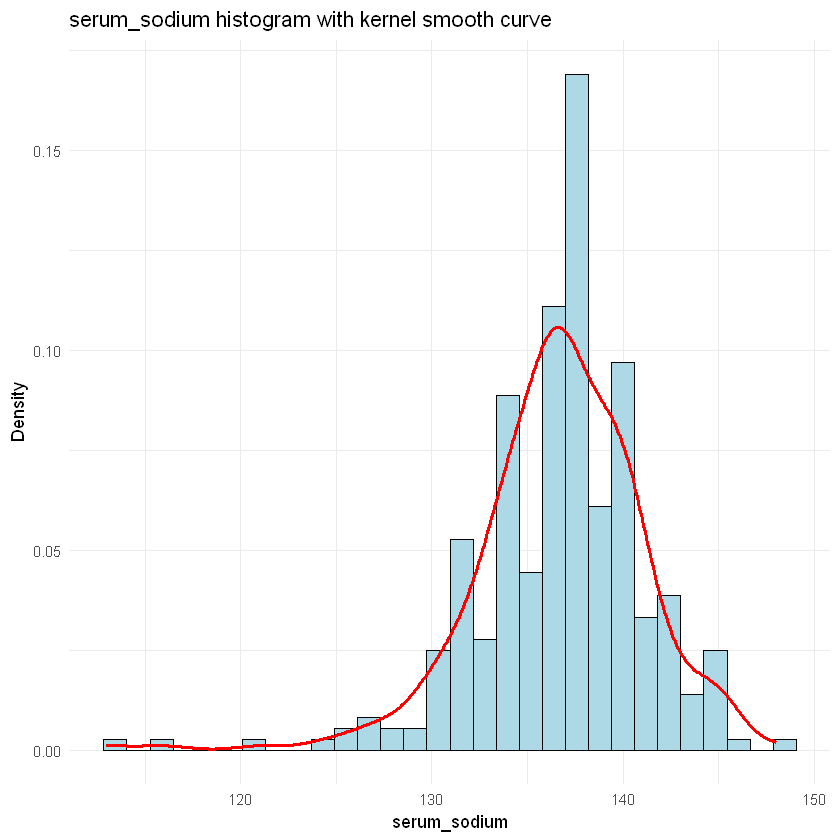

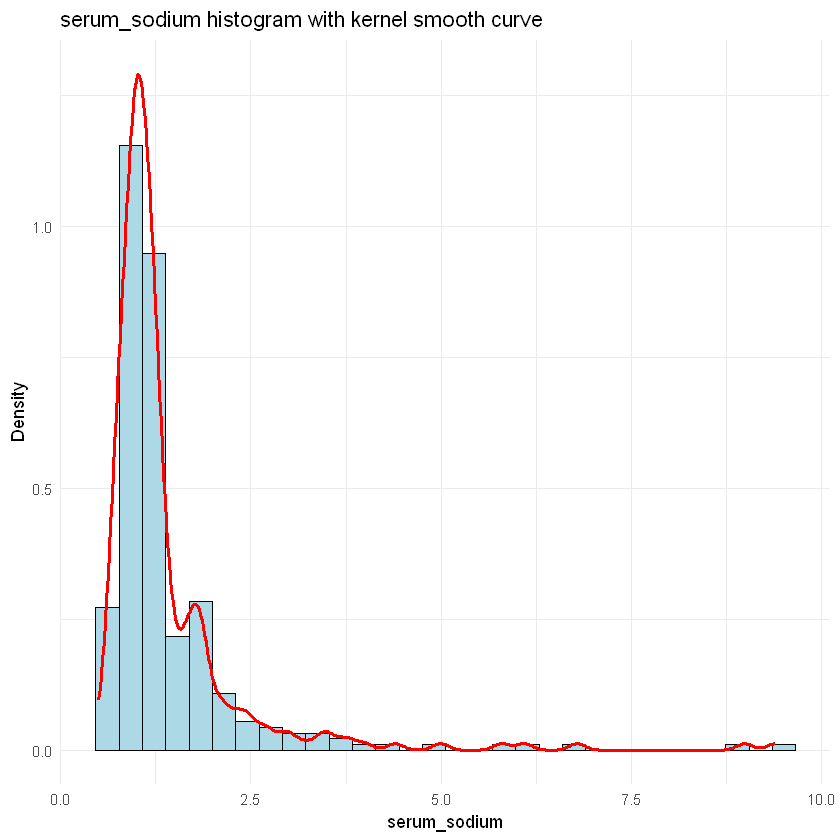

In [21]:
# Preliminary feature engineering, paying special attention to serum_sodium and serum_creatinine

# Draw histograms of the two and add kernel smoothing curves
ggplot(HFdataset, aes(x = serum_sodium)) +
   geom_histogram(aes(y = ..density..), bins = 30, fill = "lightblue", color = "black") +
   geom_density(color = "red", size = 1) +
   labs(x = "serum_sodium", y = "Density", title = "serum_sodium histogram with kernel smooth curve") +
   theme_minimal()

# Create a combined histogram and kernel smooth plot
ggplot(HFdataset, aes(x = serum_creatinine)) +
   geom_histogram(aes(y = ..density..), bins = 30, fill = "lightblue", color = "black") +
   geom_density(color = "red", size = 1) +
   labs(x = "serum_sodium", y = "Density", title = "serum_sodium histogram with kernel smooth curve") +
   theme_minimal()



# Set the upper and lower bound thresholds of serum_creatinine normal indicators
SCLower <- 0.6
SCUpper <- 1.35

#Create serum_creatinine_point feature
HFdataset$serum_creatinine_point <- ifelse(HFdataset$serum_creatinine >= SCLower & HFdataset$serum_creatinine <= SCUpper, 1, 0)

# Set the upper and lower thresholds of the normal indicator of serum_sodium
SSLower <- 135
SSUpper <- 145

#Create serum_sodium_point feature
HFdataset$serum_sodium_point <- ifelse(HFdataset$serum_sodium >= SSLower & HFdataset$serum_sodium <= SSUpper, 1, 0)

# Find the index of fatal_mi column
fatalmiIndex <- which(colnames(HFdataset) == "fatal_mi")

# Move the fatal_mi column to the last column
HFdataset <- HFdataset[, c(1:(fatalmiIndex-1), (fatalmiIndex+1):ncol(HFdataset), fatalmiIndex)]

# head(HFdataset)

In [22]:
#Load caret library
library(caret)

# Determine whether to perform SMOTE resampling
if (SMOTE_enabled == 1) {
    
#Load the libraries required for SMOTE
   library(smotefamily)
   #Perform SMOTE resampling
   oversampled_data <- SMOTE(X = HFdataset[, -ncol(HFdataset)], target = HFdataset[, ncol(HFdataset)])
   oversampled_data <- oversampled_data$data
   colnames(oversampled_data)[ncol(oversampled_data)] = 'fatal_mi'
   HFdataset <- oversampled_data
}

In [23]:
# Divide training set and test set, 70% training set, 30% test set
DataIndex <- sample(1:nrow(HFdataset), nrow(HFdataset) * 0.7)
TrainData <- HFdataset[DataIndex,]
TrainData$fatal_mi <- factor(TrainData$fatal_mi, levels = c(0, 1))
TestData <- HFdataset[-DataIndex,]

#Training set features
n_row <- ncol(HFdataset)
TrainFeature <- as.matrix(TrainData[,1:n_row-1])
TrainFeature <- scale(TrainFeature)

#Training set labels
TrainLabel <- TrainData[,n_row]

#Test set features
TestFeature <- as.matrix(TestData[,1:n_row-1])
TestFeature <- scale(TestFeature)

#Training set labels
TestLabel <- TestData[,n_row]

Warning message in train.default(x = TrainFeature, y = TrainLabel, method = "knn", :
"The metric "Accuracy" was not in the result set. Recall will be used instead."


[1] "Optimal k: "
    obs
pred  0  1
   0 47 16
   1 11 45
[1] "Recall: 0.737704918032787"
[1] "Precision: 0.803571428571429"
[1] "Specificity: 0.746031746031746"
[1] "Accuracy: 0.773109243697479"


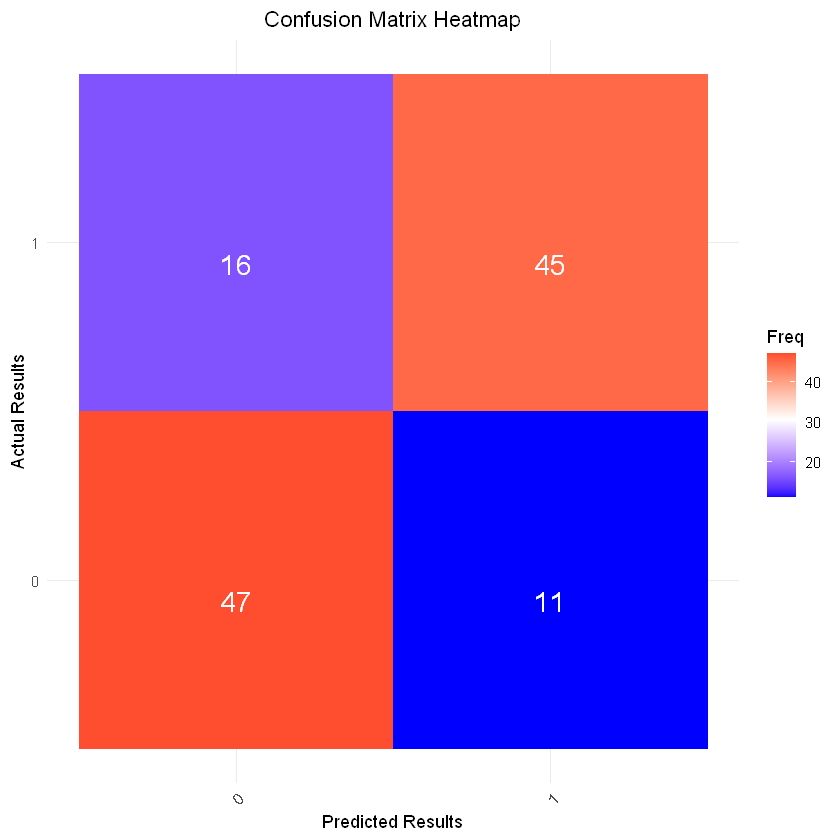

In [24]:
# Preliminary classification model exploration, using KNN model, only one feature engineering was performed before

# According to the actual situation, define the evaluation function of recall rate
RecallSummary <- function(data, lev = NULL, model = NULL) {
   recall <- sensitivity(data[, "pred"], data[, "obs"], lev[1])
   names(recall) <- "Recall"
   recall
}

#Set training control parameters and use recall rate as the evaluation indicator
KNNControl <- trainControl(method = "cv",
                            number = 5,
                            summaryFunction = RecallSummary)

# Search K for 3 5 7 9
KNNGrid <- expand.grid(.k = c(3, 5, 7, 9))

#Train KNN model
KNNmodel <- train(x = TrainFeature,
                   y = TrainLabel,
                   method = "knn",
                   trControl = KNNControl,
                   tuneGrid = KNNGrid)

# Use test set for prediction
predictions <- predict(KNNmodel, newdata = TestFeature)

# Create a data frame containing predictions and observations
KNNResult <- data.frame(pred = predictions, obs = TestLabel)
ConfusionMatrix <- table(KNNResult)

# Output the optimal k value
print(paste("Optimal k:", KNNmodel$bestTune$.k))

print(ConfusionMatrix)
# Calculate Precision
precision <- ConfusionMatrix[2, 2] / sum(ConfusionMatrix[2, ])

# Calculate Specificity
specificity <- ConfusionMatrix[1, 1] / sum(ConfusionMatrix[1, ])

# Calculate Accuracy
accuracy <- (ConfusionMatrix[1, 1] + ConfusionMatrix[2, 2]) / sum(ConfusionMatrix)

#Print evaluation indicators
print(paste("Recall:", ConfusionMatrix[2,2] / sum(ConfusionMatrix[,2])))
print(paste("Precision:", precision))
print(paste("Specificity:", specificity))
print(paste("Accuracy:", accuracy))


# Convert data format
ConfusionDF <- as.data.frame(as.table(ConfusionMatrix))


# Draw confusion matrix heat map
ggplot(ConfusionDF, aes(x = pred, y = obs, fill = Freq)) +
   geom_tile() +
   geom_text(aes(label = Freq), vjust = 1.5, color = "white", size = 6) +
   scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = median(ConfusionDF$Freq)) +
   labs(title = "Confusion Matrix Heatmap", x = "Predicted Results", y = "Actual Results") +
   theme_minimal() +
   theme(axis.text.x = element_text(angle = 45, hjust = 1),
         plot.title = element_text(hjust = 0.5))


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 11.23%
Confusion matrix:
    0   1 class.error
0 131  14  0.09655172
1  17 114  0.12977099

[1] "Recall: 0.901639344262295"
[1] "Precision: 0.901639344262295"
[1] "Specificity: 0.896551724137931"
[1] "Accuracy: 0.899159663865546"


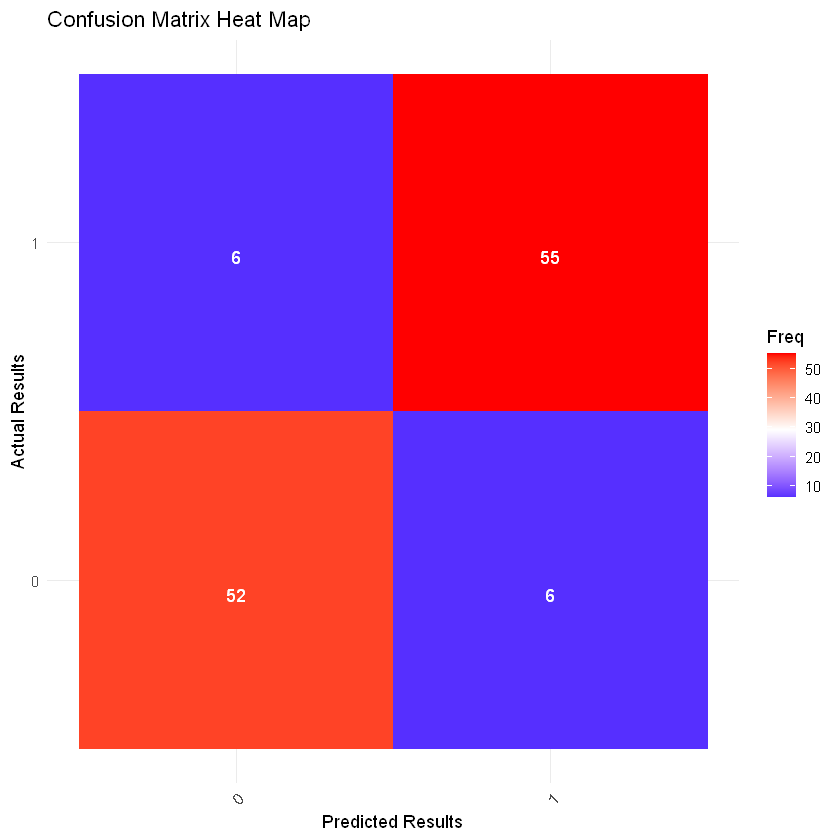

In [25]:
# Preliminary random forest, still only the first feature engineering
library(randomForest)

RepeatCV <- trainControl(method='repeatedcv', number = 5, repeats = 3 )

RandForestModel <- train(fatal_mi ~ age + creatinine_phosphokinase + .,
                   data = TrainData,
                   method = "rf",
                   trControl = RepeatCV,
                   metric = "Accuracy")
RandForestModel$finalModel

TestPred <- predict(RandForestModel, TestData)
# Calculate confusion matrix
ConfusionMatrix <- table(TestData$fatal_mi, TestPred)

# Calculate precision (Precision)
precision <- ConfusionMatrix[2, 2] / sum(ConfusionMatrix[2, ])

# Calculate specificity (Specificity)
specificity <- ConfusionMatrix[1, 1] / sum(ConfusionMatrix[1, ])

# Calculate accuracy (Accuracy)
accuracy <- (ConfusionMatrix[1, 1] + ConfusionMatrix[2, 2]) / sum(ConfusionMatrix)

# Calculate recall rate
Recall <- ConfusionMatrix[2, 2] / sum(ConfusionMatrix[2, ])

# Output evaluation indicators
print(paste("Recall:", Recall))
print(paste("Precision:", precision))
print(paste("Specificity:", specificity))
print(paste("Accuracy:", accuracy))


#Convert confusion matrix to data frame
ConfusionDf <- as.data.frame(as.table(ConfusionMatrix))

# Draw heatmap using correct column names
ggplot(data = ConfusionDf, aes(x = Var1, y = TestPred, fill = Freq)) +
   geom_tile() +
   geom_text(aes(label = Freq), vjust = 1.5, color = "white") +
   scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = median(ConfusionDf$Freq)) +
   labs(title = "Confusion Matrix Heat Map", x = "Predicted Results", y = "Actual Results") +
   theme_minimal() +
   theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

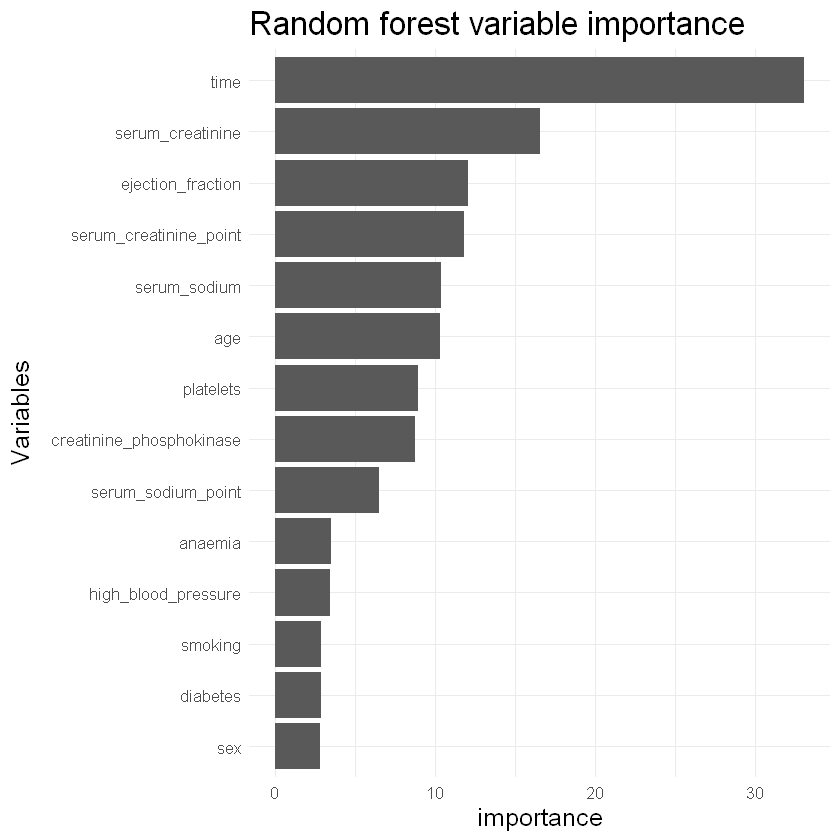

In [26]:
#Feature importance ranking
VarImp <- varImp(RandForestModel, scale=FALSE)$importance
VarImp <- data.frame(variables=row.names(VarImp), importance=VarImp$Overall)

#Set the importance threshold to 5
Selected_features <- VarImp$variables
Selected_indexes <- which(VarImp$importance > 5)

var <- VarImp[VarImp$importance>5,][order(VarImp[VarImp$importance>5,]$importance, decreasing = TRUE),]

VarImp%>%
        
         ## Sort the data by importance
         arrange(importance) %>%
        
         ## Create a ggplot object for aesthetic
         ggplot(aes(x=reorder(variables, importance), y=importance)) +
        
         ## Plot the bar graph
         geom_bar(stat='identity') +
        
         ## Flip the graph to make a horizontal bar plot
         coord_flip() +
        
         xlab('Variables') +
         labs(title='Random forest variable importance') +
         theme_minimal() +
         theme(axis.text = element_text(size = 10),
               axis.title = element_text(size = 15),
               plot.title = element_text(size = 20),
               )

In [27]:
# The second round of feature engineering, delete unimportant features, and update the training set data set
n_row <- ncol(HFdataset)
TrainFeature <- as.matrix(TrainData[,1:n_row-1])
TrainFeature <- scale(TrainFeature)
TrainFeature <- TrainFeature[,Selected_indexes]
TrainLabel <- TrainData[,n_row]

TestFeature <- as.matrix(TestData[,1:n_row-1])
TestFeature <- scale(TestFeature)
TestFeature <- TestFeature[,Selected_indexes]
TestLabel <- TestData[,n_row]


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 12.32%
Confusion matrix:
    0   1 class.error
0 127  18   0.1241379
1  16 115   0.1221374

[1] "Recall: 0.934426229508197"
[1] "Precision: 0.826086956521739"
[1] "Specificity: 0.793103448275862"
[1] "Accuracy: 0.865546218487395"


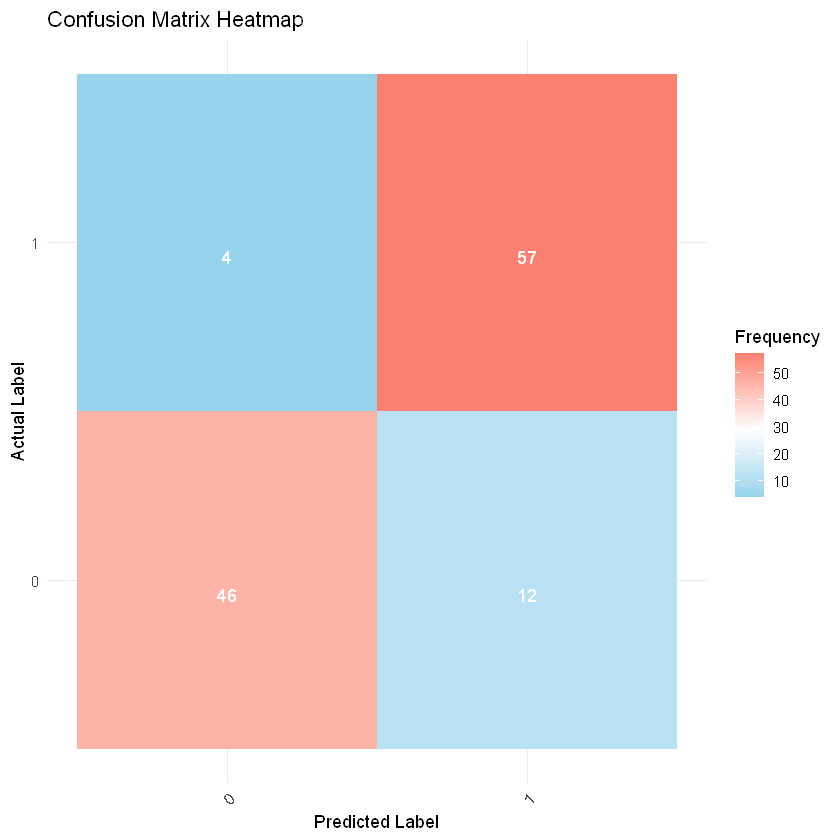

In [28]:
# Random forest training and testing after the second round of feature engineering

forest <- train(x = TrainFeature,
                 y = TrainLabel,
                   method = "rf",
                   trControl = RepeatCV,
                   metric = "Accuracy")
forest$finalModel

TestPred <- predict(forest, TestFeature)
# Calculate confusion matrix
ConfusionMatrix <- table(TestLabel, TestPred)

# Calculate precision (Precision)
precision <- ConfusionMatrix[2, 2] / sum(ConfusionMatrix[, 2])

# Calculate specificity (Specificity)
specificity <- ConfusionMatrix[1, 1] / sum(ConfusionMatrix[1, ])

# Calculate accuracy (Accuracy)
accuracy <- (ConfusionMatrix[1, 1] + ConfusionMatrix[2, 2]) / sum(ConfusionMatrix)

# Calculate recall rate
Recall <- ConfusionMatrix[2, 2] / sum(ConfusionMatrix[2, ])

# Output evaluation indicators
print(paste("Recall:", Recall))
print(paste("Precision:", precision))
print(paste("Specificity:", specificity))
print(paste("Accuracy:", accuracy))


#Convert confusion matrix to data frame
ConfusionDf <- as.data.frame(as.table(ConfusionMatrix))
names(ConfusionDf) <- c("Actual", "Predicted", "Frequency")

# Draw heat map
ggplot(data = ConfusionDf, aes(x = Predicted, y = Actual, fill = Frequency)) +
   geom_tile() +
   geom_text(aes(label = Frequency), vjust = 1.5, color = "white") +
   scale_fill_gradient2(low = "skyblue", mid = "white", high = "salmon", midpoint = median(ConfusionDf$Frequency)) +
   labs(title = "Confusion Matrix Heatmap", x = "Predicted Label", y = "Actual Label") +
   theme_minimal() +
   theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))

In [29]:
# KNN after the second round of feature engineering

#Define a recall evaluation function
recallSummary <- function(data, lev = NULL, model = NULL) {
   recall <- sensitivity(data[, "pred"], data[, "obs"], lev[1])
   names(recall) <- "Recall"
   recall
}

#Set training control parameters and use recall rate as the evaluation indicator
KNNcontrol2 <- trainControl(method = "cv",
                         number = 5,
                         summaryFunction = recallSummary)

# Set the candidate value of K
KNNGrid <- expand.grid(.k = c(3, 5, 7, 9)) # For example, the candidate values of K are 3, 5, 7, 9

#Train KNN model
KNNModel2 <- train(x = TrainFeature,
                    y = TrainLabel,
                    method = "knn",
                    trControl = KNNcontrol2,
                    tuneGrid = KNNGrid)

# Use test set for prediction
predictions <- predict(KNNModel2, newdata = TestFeature)

# Create a data frame containing predictions and observations
KNNResult <- data.frame(pred = predictions, obs = TestLabel)
ConfusionMatrix <- table(KNNResult)

# Output recall rate
ConfusionMatrix
print(paste("Recall:", ConfusionMatrix[2,2]/sum(ConfusionMatrix[,2])))

Warning message in train.default(x = TrainFeature, y = TrainLabel, method = "knn", :
"The metric "Accuracy" was not in the result set. Recall will be used instead."


    obs
pred  0  1
   0 49 12
   1  9 49

[1] "Recall: 0.80327868852459"


In [30]:
# MLP after doing all feature engineering
library(keras)
model <- keras_model_sequential()
model%>%
   layer_dense(units = 32, activation = 'relu') %>%
   layer_dense(units = 32, activation = 'relu') %>%
   layer_dense(units = 2, activation = 'softmax')

model %>% compile(
   optimizer = 'adam',
   loss = 'binary_crossentropy',
   metrics = c('accuracy')
)

In [31]:
TrainLabel <- to_categorical(TrainLabel)
TestLabel <- to_categorical(TestLabel)

In [32]:
#Train MLP model
history <- model %>% fit(
   x = TrainFeature,
   y = TrainLabel,
   epochs = 50,
   batch_size = 16,
   verbose=2
)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_5 (Dense)                    (None, 32)                      320         
 dense_4 (Dense)                    (None, 32)                      1056        
 dense_3 (Dense)                    (None, 2)                       66          
Total params: 1442 (5.63 KB)
Trainable params: 1442 (5.63 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


loss  accuracy 
0.4325334 0.8151261

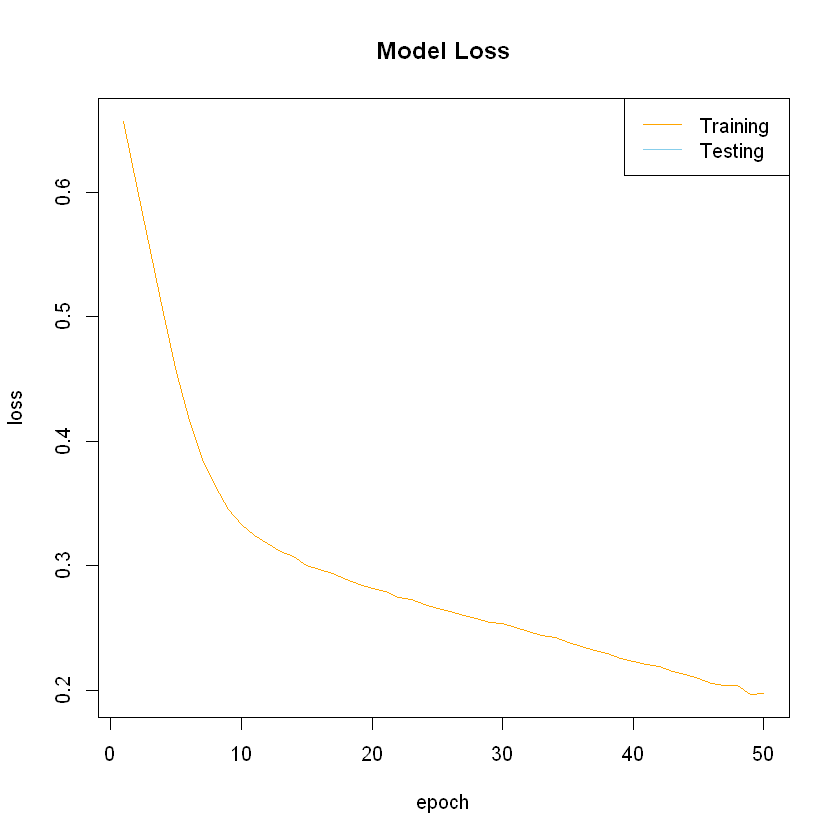

In [33]:
# Output training results
summary(model)

model %>% evaluate(TestFeature, TestLabel)

plot(history$metrics$loss, main="Model Loss", xlab = "epoch", ylab="loss", col="orange", type="l")
lines(history$metrics$val_loss, col="skyblue")
legend("topright", c("Training","Testing"), col=c("orange", "skyblue"), lty=c(1,1))

TestPred <- predict(model, TestFeature)
TestPred <- max.col(TestPred)-1

[1] "Recall: 0.80327868852459"
[1] "Precision: 0.830508474576271"
[1] "Specificity: 0.827586206896552"
[1] "Accuracy: 0.815126050420168"


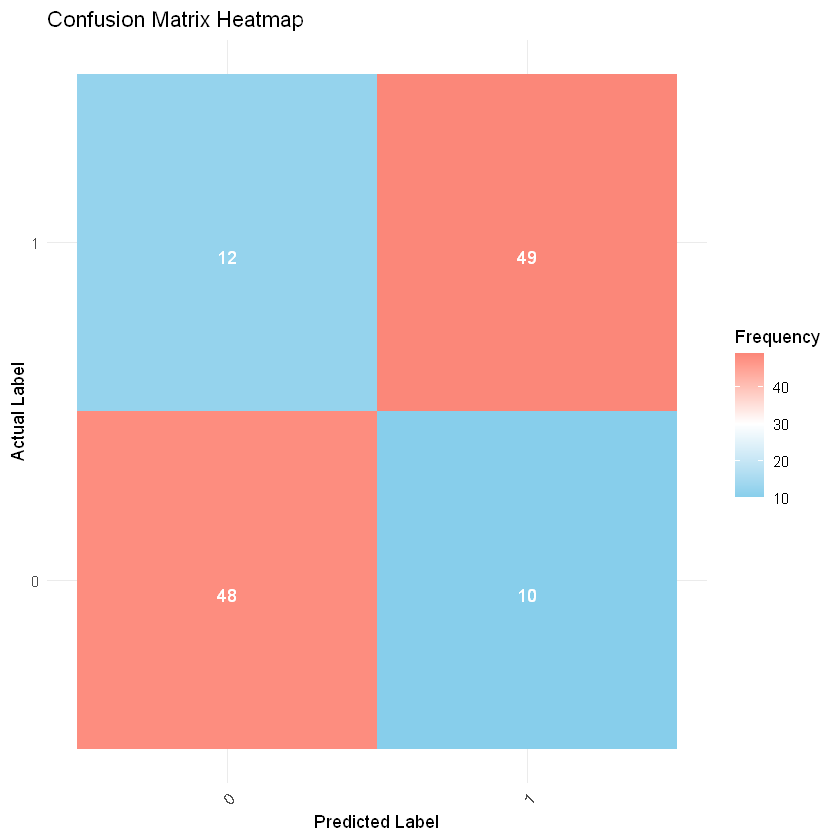

In [34]:
# Calculate confusion matrix
ConfusionMatrix <- table(TestData$fatal_mi, TestPred)


# Calculate recall rate (Recall)
Recall <- ConfusionMatrix[2, 2] / sum(ConfusionMatrix[2, ])

# Calculate precision (Precision)
precision <- ConfusionMatrix[2, 2] / sum(ConfusionMatrix[, 2])

# Calculate specificity (Specificity)
specificity <- ConfusionMatrix[1, 1] / sum(ConfusionMatrix[1, ])

# Calculate accuracy (Accuracy)
accuracy <- (ConfusionMatrix[1, 1] + ConfusionMatrix[2, 2]) / sum(ConfusionMatrix)

# Output evaluation indicators
print(paste("Recall:", Recall))
print(paste("Precision:", precision))
print(paste("Specificity:", specificity))
print(paste("Accuracy:", accuracy))

library(ggplot2)

#Convert confusion matrix to data frame
ConfusionDf <- as.data.frame(as.table(ConfusionMatrix))
names(ConfusionDf) <- c("Actual", "Predicted", "Frequency")

# Draw heat map
ggplot(data = ConfusionDf, aes(x = Predicted, y = Actual, fill = Frequency)) +
   geom_tile() +
   geom_text(aes(label = Frequency), vjust = 1.5, color = "white") +
   scale_fill_gradient2(low = "skyblue", mid = "white", high = "salmon", midpoint = median(ConfusionDf$Frequency)) +
   labs(title = "Confusion Matrix Heatmap", x = "Predicted Label", y = "Actual Label") +
   theme_minimal() +
   theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))